In [ ]:
"""
File Name: ex6_optimization.ipynb

Description: 
dataset: cycle_sum_filtered_cae_v1_t1

Author: junghwan lee
Email: jhrrlee@gmail.com
Date Created: 2023.10.15


In [2]:
import os
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
from pathlib import Path
import xlsxwriter
from tqdm import tqdm
import optuna
import pandas as pd
import time
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sqlite3
from tqdm.keras import TqdmCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

/mnt/d/sandbox/optimal_rul/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-04 20:29:30.505516: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 20:29:30.628869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 20:29:37.228250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warn

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2025-03-04 20:29:50.384816: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 20:29:50.385004: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 20:29:50.582478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 20:29:50.582536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 20:29:50.582558: I external/local_xla/xla/stream_executor

Usage

In [ ]:
import sys
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import os
import sys
drive.mount("/content/drive", force_remount=True)
sys.path.append('/content/drive/MyDrive/Colab_Notebooks')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/rul_toyota/optimization')

from pathlib import Path
gen_path = Path('/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/resource/dataset/')


In [4]:
sys.path.append('../')
sys.path.append('../../dnn_models/')
gen_path = Path('..')/'..'/'resource'/ 'dataset'

proj_dir = "/mnt/d/sandbox/optimal_rul"  # Change this to your actual project path
sys.path.append(proj_dir)


In [5]:
import prediction_evaluation as PE
from prediction_evaluation import VisualEvaluation
import resnet_cbc as rsnet
from resnet_cbc import gen_resnet152_model, gen_resnet101_model, gen_resnet50_model, gen_resnet34_model, gen_resnet18_model
import hype_optimizer_cbc as HO
from hype_optimizer_cbc import HypeOptimizer, HypeOptimizer_v2
import data_distribution as DD
importlib.reload(rsnet)
importlib.reload(DD)
importlib.reload(PE)
importlib.reload(HO)

<module 'hype_optimizer_cbc' from '/mnt/d/sandbox/optimal_rul/optimization_v2/ex0/../hype_optimizer_cbc.py'>

In [6]:
battery_ids  = np.load(gen_path / 'battery_ids.npy')
eol = np.load(gen_path / 'eol_21_120.npy')
#cycle_data = np.load(gen_path / 'interpolated_cycle_data_21_120.npy')
new_cycle_sum = np.load(gen_path / 'new_cycle_sum_21_120.npy')

In [7]:
num_cells = eol.shape[0]
num_cycles = new_cycle_sum.shape[2]

# Repeat the EOL values for each cycle in the cycle_count array
eol_repeated = np.tile(eol, (1, num_cycles))
cycle_count = np.arange(1, num_cycles+1)
# Repeat the cycle_count values for each cell in the cycle_count array
cycle_count_repeated = np.tile(cycle_count, (num_cells, 1))
RUL = eol - num_cycles
RUL_repeated = eol_repeated - cycle_count_repeated

print("RUL shape:", RUL.shape)
print("RUL_repeated shape:", RUL_repeated.shape)
print("eol repeated shape:", eol_repeated.shape)
print("cycle_count shape:", cycle_count_repeated.shape)
print("eol shape:", eol.shape)
print("cycle_count shape:", cycle_count_repeated.shape)
print("new_cycle_sum shape:", new_cycle_sum.shape)

RUL shape: (124, 1)
RUL_repeated shape: (124, 100)
eol repeated shape: (124, 100)
cycle_count shape: (124, 100)
eol shape: (124, 1)
cycle_count shape: (124, 100)
new_cycle_sum shape: (124, 14, 100)


In [8]:
sorted_eol = np.sort(eol, axis=0)
sorted_eol_values = np.unique(sorted_eol, return_counts=True)
print(sorted_eol_values)

(array([ 148.,  300.,  335.,  429.,  438.,  444.,  457.,  458.,  459.,
        461.,  462.,  463.,  465.,  466.,  468.,  471.,  477.,  478.,
        480.,  481.,  483.,  485.,  487.,  489.,  492.,  494.,  495.,
        498.,  499.,  502.,  509.,  511.,  513.,  519.,  520.,  527.,
        534.,  535.,  541.,  559.,  561.,  599.,  616.,  617.,  625.,
        636.,  648.,  651.,  667.,  691.,  702.,  703.,  704.,  709.,
        713.,  719.,  731.,  742.,  757.,  772.,  786.,  788.,  796.,
        813.,  816.,  817.,  825.,  828.,  842.,  850.,  854.,  857.,
        858.,  860.,  862.,  870.,  876.,  880.,  917.,  923.,  932.,
        935.,  940.,  966.,  989., 1002., 1009., 1014., 1017., 1028.,
       1039., 1048., 1051., 1054., 1063., 1074., 1078., 1093., 1115.,
       1146., 1155., 1156., 1158., 1284., 1315., 1434., 1638., 1709.,
       1801., 1836., 1852., 1935., 2160., 2237.]), array([1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 1

In [9]:
# Calculate quantile values
quantiles = [np.percentile(sorted_eol, q=i) for i in range(10, 100, 10)]
# Print quantiles
print(quantiles)
# You can use these quantiles as bin edges for stratification
bins = [-np.inf] + quantiles + [np.inf]
print(bins)

[462.3, 487.0, 518.4, 638.4000000000001, 736.5, 828.0, 876.4, 1021.4000000000001, 1155.7]
[-inf, 462.3, 487.0, 518.4, 638.4000000000001, 736.5, 828.0, 876.4, 1021.4000000000001, 1155.7, inf]


In [10]:
def generate_bins(sorted_eol, train_percent=0.8):
    N = len(sorted_eol)
    min_samples = int(N / train_percent * (1 - train_percent))
    
    unique_values, counts = np.unique(sorted_eol, return_counts=True)
    
    bins = [float('-inf')]
    running_total = 0

    for val, count in zip(unique_values, counts):
        running_total += count
        if running_total >= min_samples:
            bins.append(val)
            running_total = 0

    bins.append(float('inf'))
    
    return bins
    

In [11]:
bins = generate_bins(sorted_eol, 0.8)

In [12]:
bins

[-inf, 495.0, 719.0, 923.0, 1836.0, inf]

In [13]:
# no. of cell, no. of cycles, no. of features
transposed_cycle_sum = np.transpose(new_cycle_sum, axes=(0, 2, 1))

# split data
(X_train,
 X_val,
 y_train,
 y_val,
 indices_train,
 indices_val) = DD.data_distribution(transposed_cycle_sum, RUL_repeated, eol_repeated, 0.8, bins)

# for cycle by cycle, samples = no. of cell * no. of cycles
X_train = X_train.reshape(-1, X_train.shape[-1])
X_val = X_val.reshape(-1, X_val.shape[-1])
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# generate scalers using training data.
X_scaler, y_scaler = DD.fit_scalers(X_train, y_train)
X_train_norm, y_train_norm = DD.apply_normalization(X_train, y_train, X_scaler, y_scaler)
X_val_norm, y_val_norm = DD.apply_normalization(X_val, y_val, X_scaler, y_scaler)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(X_train_norm.shape, X_val_norm.shape, y_train_norm.shape, y_val_norm.shape)
print('indices_train:', indices_train)
print('indices_val:', indices_val)
DD.save_scalers(X_scaler, y_scaler)

(9900, 14) (2500, 14) (9900, 1) (2500, 1)
(9900, 14) (2500, 14) (9900, 1) (2500, 1)
indices_train: [  6  55  53  90  88  82  75  33  26  19  18  96   4  99  11  74  54  79
  22  15  12  17  36  81  69   9   0  20  48 113  86  41  56  40  57 101
  98 107  85  51  73   1 123  21  71  34  89  92  25 109  62   2  76 112
  61  70  59  14   7  60  43  93  50  37  52  30 118  16  64  67  97 106
 104  78 116 122 115  49  35  80  68  65  83 119 120 114  95  13 110  10
 100 103  63   8  44  87   3  94 121]
indices_val: [ 77  24  32  58  38  42  28 105   5  45  27  66  91  29  47 102  72 117
  23  31  84  39 108  46 111]
X_scaler saved as X_scaler.pkl
y_scaler saved as y_scaler.pkl


In [14]:
# Reshape the input data to the channel dimension
X_train_norm = X_train_norm.reshape(X_train_norm.shape[0], X_train_norm.shape[1], 1)
X_val_norm = X_val_norm.reshape(X_val_norm.shape[0], X_val_norm.shape[1], 1)

print(X_train_norm.shape, X_val_norm.shape)

(9900, 14, 1) (2500, 14, 1)


In [15]:
from pathlib import Path  # Ensure this is imported

grid_search_space = {
    'batch_size': [1, 2, 4, 8, 16],
    'batch_norm': [1, 0]
}

custom_objects = {
    "mean_absolute_percentage_error": HO.mean_absolute_percentage_error,
    "root_mean_squared_error": HO.root_mean_squared_error
}

def hype_space(trial, input_shape):
    # Use values directly from grid_search_space
    batch_size = trial.suggest_categorical('batch_size', grid_search_space['batch_size'])
    batch_norm = trial.suggest_categorical('batch_norm', grid_search_space['batch_norm'])

    use_bn = True if batch_norm == 1 else False  # Fix logic

    model = gen_resnet34_model(
        input_shape, 
        kernel_size=3,
        strides=2,
        activation='leaky_relu', 
        learning_rate=0.0001, 
        loss='mse',
        metrics=['mean_absolute_error', 'mean_squared_error', HO.mean_absolute_percentage_error, HO.root_mean_squared_error],
        use_bn=use_bn
    )

    return model, batch_size

In [16]:
# for test handling kernel crash
db_name = 'resnet_34_ex0.db'
study_name = 'resnet_34_ex0'
n_trial = 10
base_path = Path('./training_data/')


sampler = optuna.samplers.GridSampler(grid_search_space)
optimizer = HypeOptimizer_v2(sampler, hype_space, custom_objects, n_trial, base_path, db_name, study_name, direction='minimize')


Study Folder 'training_data/resnet_34_ex0' already exists!
DB Folder 'training_data/db' already exists!


[I 2025-03-04 20:29:52,567] Using an existing study with name 'resnet_34_ex0' instead of creating a new one.


In [25]:
optimizer.run(X_train_norm, y_train_norm, X_val_norm, y_val_norm, y_scaler, y_train, y_val, max_epoch=500, patience=50)

traial:  0
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_0.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_0.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_0.xlsx
🚀 No previous model found. Initializing a new model.


2025-03-02 13:02:15.326107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 13:02:15.326194: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 13:02:15.326231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 13:02:15.326253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 13:02:15.326272: I external/local_xla/xla/stream_executor

trial: <optuna.trial._trial.Trial object at 0x7f5242428ca0> training_data/resnet_34_ex0/epoch_info/epoch_info_0.txt


  0%|          | 0/500 [00:00<?, ?epoch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1740888139.570713    9751 service.cc:145] XLA service 0x7f5078004880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740888139.570757    9751 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1740888139.570761    9751 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-02 13:02:20.193181: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-02 13:02:21.269833: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1740888145.211891    9751 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetim

310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Training set metrics:
RMSE: 60.5327206450701
MAE: 34.06535587503453
MAPE: 0.04300072704472321
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation set metrics:
RMSE: 118.24175237141561
MAE: 77.15064681396484
MAPE: 0.24881876399114147


[I 2025-03-02 13:31:14,501] Trial 0 finished with value: 0.14590974551793234 and parameters: {'batch_size': 4, 'batch_norm': 0}. Best is trial 0 with value: 0.14590974551793234.


traial:  1
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_1.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_1.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_1.xlsx
🚀 No previous model found. Initializing a new model.
trial: <optuna.trial._trial.Trial object at 0x7f511c1f4070> training_data/resnet_34_ex0/epoch_info/epoch_info_1.txt


 10%|█         | 50/500 [1:13:19<10:59:53, 87.99s/epoch, loss=0.0395, mean_absolute_error=0.146, mean_absolute_percentage_error=0.907, mean_squared_error=0.0395, root_mean_squared_error=0.146, val_loss=inf, val_mean_absolute_error=3.64e+23, val_mean_absolute_percentage_error=4.62e+24, val_mean_squared_error=inf, val_root_mean_squared_error=inf] 


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Training set metrics:
RMSE: 8.332816065727204e+26
MAE: 7.732146195294792e+26
MAPE: 1.219707263353366e+24
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Validation set metrics:
RMSE: 8.050448474930239e+26
MAE: 7.403032068935751e+26
MAPE: 1.761246168316151e+24


[I 2025-03-02 14:44:38,098] Trial 1 finished with value: 1.4904767158347585e+24 and parameters: {'batch_size': 1, 'batch_norm': 1}. Best is trial 0 with value: 0.14590974551793234.


traial:  2
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_2.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_2.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_2.xlsx
🚀 No previous model found. Initializing a new model.
trial: <optuna.trial._trial.Trial object at 0x7f52419e4f10> training_data/resnet_34_ex0/epoch_info/epoch_info_2.txt


 27%|██▋       | 136/500 [13:27<36:01,  5.94s/epoch, loss=0.000782, mean_absolute_error=0.0201, mean_absolute_percentage_error=0.101, mean_squared_error=0.000782, root_mean_squared_error=0.0267, val_loss=0.0093, val_mean_absolute_error=0.0569, val_mean_absolute_percentage_error=0.485, val_mean_squared_error=0.0093, val_root_mean_squared_error=0.0598]   


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Training set metrics:
RMSE: 108.91767560414277
MAE: 80.38008338465835
MAPE: 0.12115643550038817
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation set metrics:
RMSE: 115.87895130290909
MAE: 90.43459625854493
MAPE: 0.22378498285443857


[I 2025-03-02 14:58:11,922] Trial 2 finished with value: 0.17247070917741336 and parameters: {'batch_size': 16, 'batch_norm': 1}. Best is trial 0 with value: 0.14590974551793234.


traial:  3
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_3.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_3.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_3.xlsx
🚀 No previous model found. Initializing a new model.
trial: <optuna.trial._trial.Trial object at 0x7f5241a5cc70> training_data/resnet_34_ex0/epoch_info/epoch_info_3.txt


 27%|██▋       | 136/500 [10:06<27:03,  4.46s/epoch, loss=8.42e-5, mean_absolute_error=0.00609, mean_absolute_percentage_error=0.0311, mean_squared_error=8.42e-5, root_mean_squared_error=0.00844, val_loss=0.00506, val_mean_absolute_error=0.052, val_mean_absolute_percentage_error=0.578, val_mean_squared_error=0.00506, val_root_mean_squared_error=0.0541]   


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training set metrics:
RMSE: 38.40055266022267
MAE: 25.74486658423838
MAPE: 0.03558289544455142
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation set metrics:
RMSE: 117.43393822709969
MAE: 85.35544247436523
MAPE: 0.2185643353608535


[I 2025-03-02 15:08:23,116] Trial 3 finished with value: 0.12707361540270246 and parameters: {'batch_size': 16, 'batch_norm': 0}. Best is trial 3 with value: 0.12707361540270246.


traial:  4
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_4.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_4.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_4.xlsx
🚀 No previous model found. Initializing a new model.
trial: <optuna.trial._trial.Trial object at 0x7f5241a5cc70> training_data/resnet_34_ex0/epoch_info/epoch_info_4.txt


 13%|█▎        | 67/500 [1:14:36<8:02:07, 66.81s/epoch, loss=0.000149, mean_absolute_error=0.0078, mean_absolute_percentage_error=0.0428, mean_squared_error=0.000149, root_mean_squared_error=0.00796, val_loss=0.00453, val_mean_absolute_error=0.0446, val_mean_absolute_percentage_error=0.614, val_mean_squared_error=0.00453, val_root_mean_squared_error=0.0446] 


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training set metrics:
RMSE: 32.87237319604112
MAE: 24.142448238796657
MAPE: 0.03712122296588726
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation set metrics:
RMSE: 117.6953761514081
MAE: 76.29715909423828
MAPE: 0.24681201725549523


[I 2025-03-02 16:23:04,109] Trial 4 finished with value: 0.14196662011069125 and parameters: {'batch_size': 1, 'batch_norm': 0}. Best is trial 3 with value: 0.12707361540270246.


traial:  5
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_5.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_5.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_5.xlsx
🚀 No previous model found. Initializing a new model.
trial: <optuna.trial._trial.Trial object at 0x7f50147034f0> training_data/resnet_34_ex0/epoch_info/epoch_info_5.txt


 11%|█         | 55/500 [29:26<3:58:12, 32.12s/epoch, loss=0.000129, mean_absolute_error=0.00805, mean_absolute_percentage_error=0.0474, mean_squared_error=0.000129, root_mean_squared_error=0.0092, val_loss=0.00423, val_mean_absolute_error=0.0441, val_mean_absolute_percentage_error=0.559, val_mean_squared_error=0.00423, val_root_mean_squared_error=0.0447] 


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training set metrics:
RMSE: 128.56576385103625
MAE: 85.56706433382901
MAPE: 0.11407836713819189
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation set metrics:
RMSE: 110.39047501601563
MAE: 88.8635583618164
MAPE: 0.2499925507694585


[I 2025-03-02 16:52:35,550] Trial 5 finished with value: 0.1820354589538252 and parameters: {'batch_size': 2, 'batch_norm': 0}. Best is trial 3 with value: 0.12707361540270246.


traial:  6
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_6.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_6.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_6.xlsx
🚀 No previous model found. Initializing a new model.
trial: <optuna.trial._trial.Trial object at 0x7f505833b820> training_data/resnet_34_ex0/epoch_info/epoch_info_6.txt


 15%|█▌        | 75/500 [10:22<58:47,  8.30s/epoch, loss=0.000109, mean_absolute_error=0.00726, mean_absolute_percentage_error=0.0378, mean_squared_error=0.000109, root_mean_squared_error=0.00956, val_loss=0.00501, val_mean_absolute_error=0.0512, val_mean_absolute_percentage_error=0.552, val_mean_squared_error=0.00501, val_root_mean_squared_error=0.0525]


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training set metrics:
RMSE: 60.24407036540952
MAE: 42.32230356389826
MAPE: 0.054559789870859805
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation set metrics:
RMSE: 105.84032298756111
MAE: 76.72551450195313
MAPE: 0.21727686185984402


[I 2025-03-02 17:03:02,842] Trial 6 finished with value: 0.1359183258653519 and parameters: {'batch_size': 8, 'batch_norm': 0}. Best is trial 3 with value: 0.12707361540270246.


traial:  7
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_7.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_7.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_7.xlsx
🚀 No previous model found. Initializing a new model.
trial: <optuna.trial._trial.Trial object at 0x7f5074bede10> training_data/resnet_34_ex0/epoch_info/epoch_info_7.txt


 11%|█         | 54/500 [39:11<5:23:43, 43.55s/epoch, loss=0.0367, mean_absolute_error=0.14, mean_absolute_percentage_error=0.837, mean_squared_error=0.0367, root_mean_squared_error=0.159, val_loss=3.27e+5, val_mean_absolute_error=365, val_mean_absolute_percentage_error=2.22e+3, val_mean_squared_error=3.27e+5, val_root_mean_squared_error=377]   


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Training set metrics:
RMSE: 1542.5250935598253
MAE: 1231.1902690461309
MAPE: 2.252867736876632
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation set metrics:
RMSE: 1877.7739877798456
MAE: 1543.6593104391097
MAPE: 3.6616246750372667


[I 2025-03-02 17:42:21,435] Trial 7 finished with value: 2.9572462059569493 and parameters: {'batch_size': 2, 'batch_norm': 1}. Best is trial 3 with value: 0.12707361540270246.


traial:  8
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_8.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_8.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_8.xlsx
🚀 No previous model found. Initializing a new model.
trial: <optuna.trial._trial.Trial object at 0x7f4fd47c4160> training_data/resnet_34_ex0/epoch_info/epoch_info_8.txt


 23%|██▎       | 114/500 [21:38<1:13:16, 11.39s/epoch, loss=0.00115, mean_absolute_error=0.0263, mean_absolute_percentage_error=0.164, mean_squared_error=0.00115, root_mean_squared_error=0.0323, val_loss=0.0115, val_mean_absolute_error=0.087, val_mean_absolute_percentage_error=1.26, val_mean_squared_error=0.0115, val_root_mean_squared_error=0.0892]    


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Training set metrics:
RMSE: 94.53477503595188
MAE: 77.24413320305372
MAPE: 0.11635070965952052
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Validation set metrics:
RMSE: 121.12949860430844
MAE: 84.33431016845704
MAPE: 0.2529873042581859


[I 2025-03-02 18:04:07,368] Trial 8 finished with value: 0.1846690069588532 and parameters: {'batch_size': 8, 'batch_norm': 1}. Best is trial 3 with value: 0.12707361540270246.


traial:  9
epoch_file_name:  training_data/resnet_34_ex0/epoch_info/epoch_info_9.txt
model_name:  training_data/resnet_34_ex0/models/resnet_34_ex0_9.keras
savefile_name:  training_data/resnet_34_ex0/results/resnet_34_ex0_results_9.xlsx
🚀 No previous model found. Initializing a new model.
trial: <optuna.trial._trial.Trial object at 0x7f50347eb910> training_data/resnet_34_ex0/epoch_info/epoch_info_9.txt


 29%|██▉       | 144/500 [1:24:02<3:27:45, 35.02s/epoch, loss=0.00304, mean_absolute_error=0.0411, mean_absolute_percentage_error=0.224, mean_squared_error=0.00304, root_mean_squared_error=0.0491, val_loss=4.87, val_mean_absolute_error=0.904, val_mean_absolute_percentage_error=3.22, val_mean_squared_error=4.87, val_root_mean_squared_error=0.921]         


310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Training set metrics:
RMSE: 154.11284855356297
MAE: 105.36630268246236
MAPE: 0.1708429474640636
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation set metrics:
RMSE: 150.51580948807893
MAE: 104.85192560119629
MAPE: 0.31552122141379213


[I 2025-03-02 19:28:17,370] Trial 9 finished with value: 0.24318208443892786 and parameters: {'batch_size': 4, 'batch_norm': 1}. Best is trial 3 with value: 0.12707361540270246.


Best Hyperparameters: {'batch_size': 16, 'batch_norm': 0}
Best score: 0.12707361540270246


,number,MAPE,params_batch_norm,params_batch_size,state,Prediction Time (ms),user_attrs_train_mae_rul,user_attrs_train_mape_rul,user_attrs_train_rmse_rul,user_attrs_training_time,user_attrs_val_mae_rul,user_attrs_val_mape_rul,user_attrs_val_rmse_rul
0,0,1.459097e-01,0,4,COMPLETE,2775.305271,3.406536e+01,4.300073e-02,6.053272e+01,1733.455412,7.715065e+01,2.488188e-01,1.182418e+02
1,1,1.490477e+24,1,1,COMPLETE,3200.896263,7.732146e+26,1.219707e+24,8.332816e+26,4399.329757,7.403032e+26,1.761246e+24,8.050448e+26
2,2,1.724707e-01,1,16,COMPLETE,2909.952641,8.038008e+01,1.211564e-01,1.089177e+02,807.625724,9.043460e+01,2.237850e-01,1.158790e+02
3,3,1.270736e-01,0,16,COMPLETE,1707.912683,2.574487e+01,3.558290e-02,3.840055e+01,606.626238,8.535544e+01,2.185643e-01,1.174339e+02
4,4,1.419666e-01,0,1,COMPLETE,1793.318987,2.414245e+01,3.712122e-02,3.287237e+01,4476.129683,7.629716e+01,2.468120e-01,1.176954e+02
5,5,1.820355e-01,0,2,COMPLETE,1752.321005,8.556706e+01,1.140784e-01,1.285658e+02,1766.561131,8.886356e+01,2.499926e-01,1.103905e+02
6,6,1.359183e-01,0,8,COMPLETE,1732.304335,4.232230e+01,5.455979e-02,6.024407e+01,622.469679,7.672551e+01,2.172769e-01,1.058403e+02
7,7,2.957246e+00,1,2,COMPLETE,2952.186108,1.231190e+03,2.252868e+00,1.542525e+03,2351.784141,1.543659e+03,3.661625e+00,1.877774e+03
8,8,1.846690e-01,1,8,COMPLETE,3043.015718,7.724413e+01,1.163507e-01,9.453478e+01,1298.539398,8.433431e+01,2.529873e-01,1.211295e+02
9,9,2.431821e-01,1,4,COMPLETE,3284.706354,1.053663e+02,1.708429e-01,1.541128e+02,5042.270191,1.048519e+02,3.155212e-01,1.505158e+02


In [17]:
df = optimizer.get_trial_results()

In [18]:
df.to_csv(base_path / study_name /'trials.csv', index=False)

In [19]:
df

,number,MAPE,params_batch_norm,params_batch_size,state,Prediction Time (ms),user_attrs_train_mae_rul,user_attrs_train_mape_rul,user_attrs_train_rmse_rul,user_attrs_training_time,user_attrs_val_mae_rul,user_attrs_val_mape_rul,user_attrs_val_rmse_rul
0,0,1.459097e-01,0,4,COMPLETE,2775.305271,3.406536e+01,4.300073e-02,6.053272e+01,1733.455412,7.715065e+01,2.488188e-01,1.182418e+02
1,1,1.490477e+24,1,1,COMPLETE,3200.896263,7.732146e+26,1.219707e+24,8.332816e+26,4399.329757,7.403032e+26,1.761246e+24,8.050448e+26
2,2,1.724707e-01,1,16,COMPLETE,2909.952641,8.038008e+01,1.211564e-01,1.089177e+02,807.625724,9.043460e+01,2.237850e-01,1.158790e+02
3,3,1.270736e-01,0,16,COMPLETE,1707.912683,2.574487e+01,3.558290e-02,3.840055e+01,606.626238,8.535544e+01,2.185643e-01,1.174339e+02
4,4,1.419666e-01,0,1,COMPLETE,1793.318987,2.414245e+01,3.712122e-02,3.287237e+01,4476.129683,7.629716e+01,2.468120e-01,1.176954e+02
5,5,1.820355e-01,0,2,COMPLETE,1752.321005,8.556706e+01,1.140784e-01,1.285658e+02,1766.561131,8.886356e+01,2.499926e-01,1.103905e+02
6,6,1.359183e-01,0,8,COMPLETE,1732.304335,4.232230e+01,5.455979e-02,6.024407e+01,622.469679,7.672551e+01,2.172769e-01,1.058403e+02
7,7,2.957246e+00,1,2,COMPLETE,2952.186108,1.231190e+03,2.252868e+00,1.542525e+03,2351.784141,1.543659e+03,3.661625e+00,1.877774e+03
8,8,1.846690e-01,1,8,COMPLETE,3043.015718,7.724413e+01,1.163507e-01,9.453478e+01,1298.539398,8.433431e+01,2.529873e-01,1.211295e+02
9,9,2.431821e-01,1,4,COMPLETE,3284.706354,1.053663e+02,1.708429e-01,1.541128e+02,5042.270191,1.048519e+02,3.155212e-01,1.505158e+02


In [20]:
trained_model = optimizer.get_trained_model(3)

2025-03-04 20:30:00.528814: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 20:30:00.528914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 20:30:00.528949: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 20:30:00.528970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 20:30:00.528989: I external/local_xla/xla/stream_executor

In [20]:
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 7, 64)        512         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 7, 64)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 4, 64)        0           activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in trained_model.layers:
    weights = layer.get_weights()
    print(weights)

In [21]:
X_scaler, y_scaler = DD.load_scalers()

In [22]:
transposed_cycle_sum.shape

(124, 100, 14)

In [23]:
reshaped_cycle_sum = transposed_cycle_sum.reshape(-1, transposed_cycle_sum.shape[-1])
reshaped_rul = RUL_repeated.reshape(-1, 1)
X_test_norm, y_test_norm = DD.apply_normalization(reshaped_cycle_sum, reshaped_rul, X_scaler, y_scaler)

In [24]:
# evaluation using normalied data.
loss, mae, mse, mape, rmse = trained_model.evaluate(X_test_norm, y_test_norm)
print(f"Loss: {loss}, Mean Absolute Error: {mae}, Mean Squared Error: {mse}, Mean Absolute Percentage Error: {mape}, Root Mean Squared Error: {rmse}")

I0000 00:00:1741087810.311129  282913 service.cc:145] XLA service 0x7f5aac0286a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741087810.311244  282913 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1741087810.311248  282913 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-04 20:30:10.374761: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-04 20:30:10.445767: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 45/388 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 0.0533 - mean_squared_error: 0.0010 - root_mean_squared_error: 0.0256        

I0000 00:00:1741087811.560685  282913 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0011 - mean_absolute_error: 0.0209 - mean_absolute_percentage_error: 0.1351 - mean_squared_error: 0.0011 - root_mean_squared_error: 0.0232
Loss: 0.0009547426598146558, Mean Absolute Error: 0.018547704443335533, Mean Squared Error: 0.0009547426598146558, Mean Absolute Percentage Error: 0.1285049468278885, Root Mean Squared Error: 0.02074107713997364


In [25]:
# unnormalized x: (, 14)
ruls = PE.RUL_predict(trained_model, reshaped_cycle_sum, X_scaler, y_scaler)

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [26]:
print(ruls)

[[1794]
 [1802]
 [1770]
 ...
 [1715]
 [1724]
 [1727]]


In [27]:
results = PE.evaluate_predictions(reshaped_rul, ruls)
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

MSE: 3957.3204
RMSE: 62.9072
MAE: 37.7614
MAPE: 7.2469


/mnt/d/sandbox/optimal_rul/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


usage of Visual evaluation

In [53]:
import prediction_evaluation
importlib.reload(prediction_evaluation)
from prediction_evaluation import VisualEvaluation


In [54]:
vev = VisualEvaluation(reshaped_rul, ruls, transposed_cycle_sum.shape[0], transposed_cycle_sum.shape[1])

/mnt/d/sandbox/optimal_rul/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/mnt/d/sandbox/optimal_rul/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/mnt/d/sandbox/optimal_rul/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/mnt/d/sandbox/optimal_rul/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 an

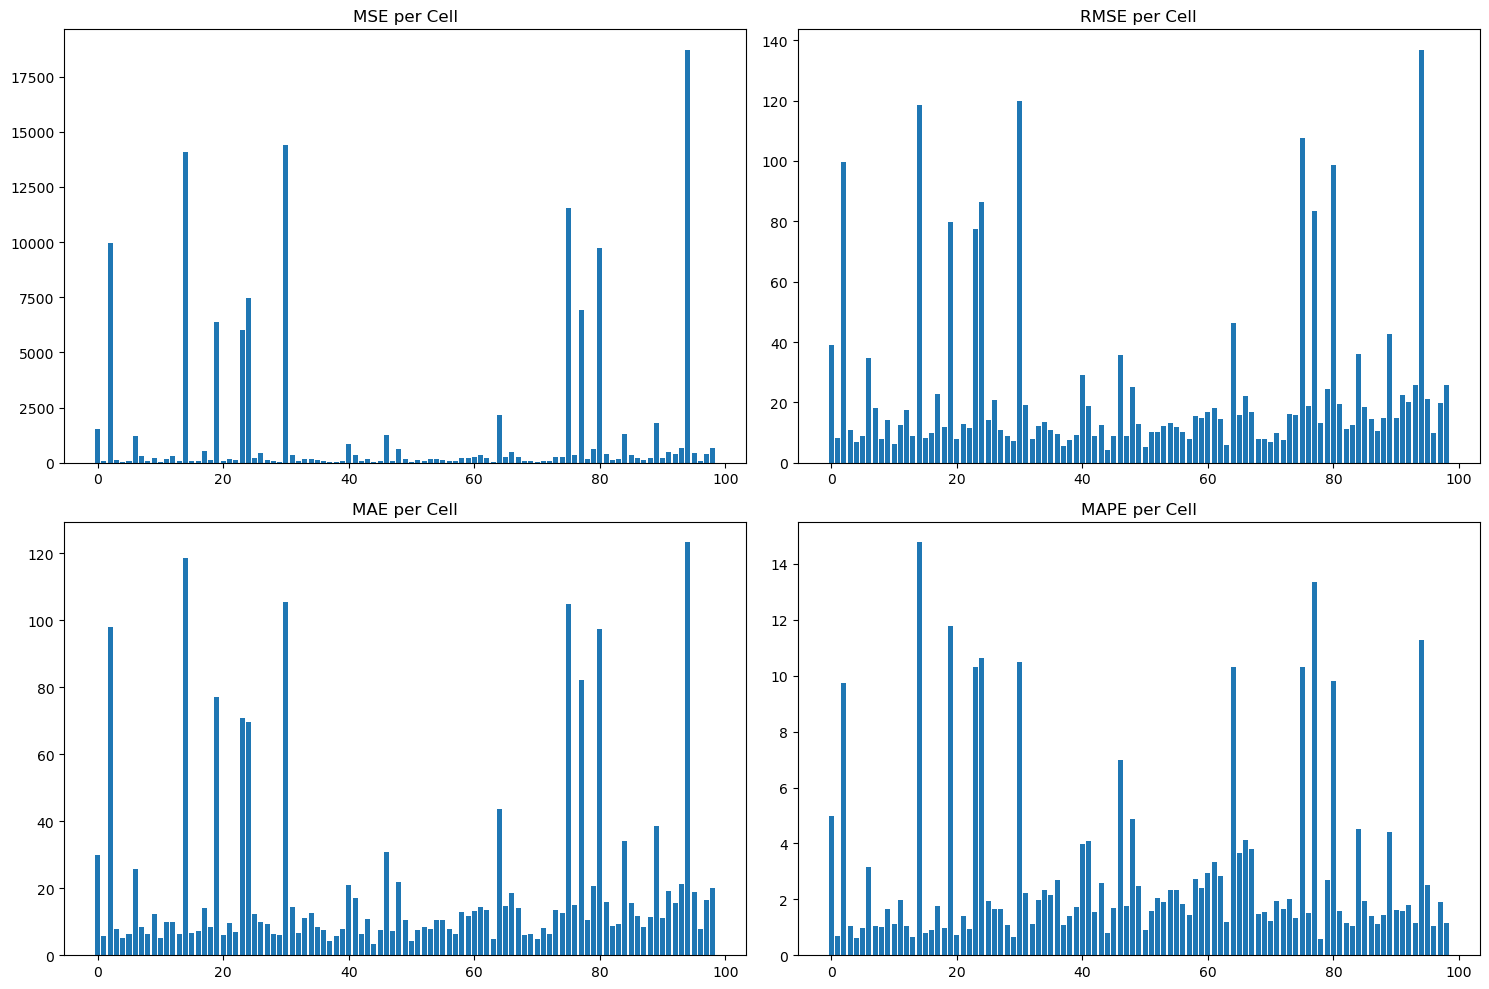

In [27]:
mses, rmses, maes, mapes = vev.metrics()

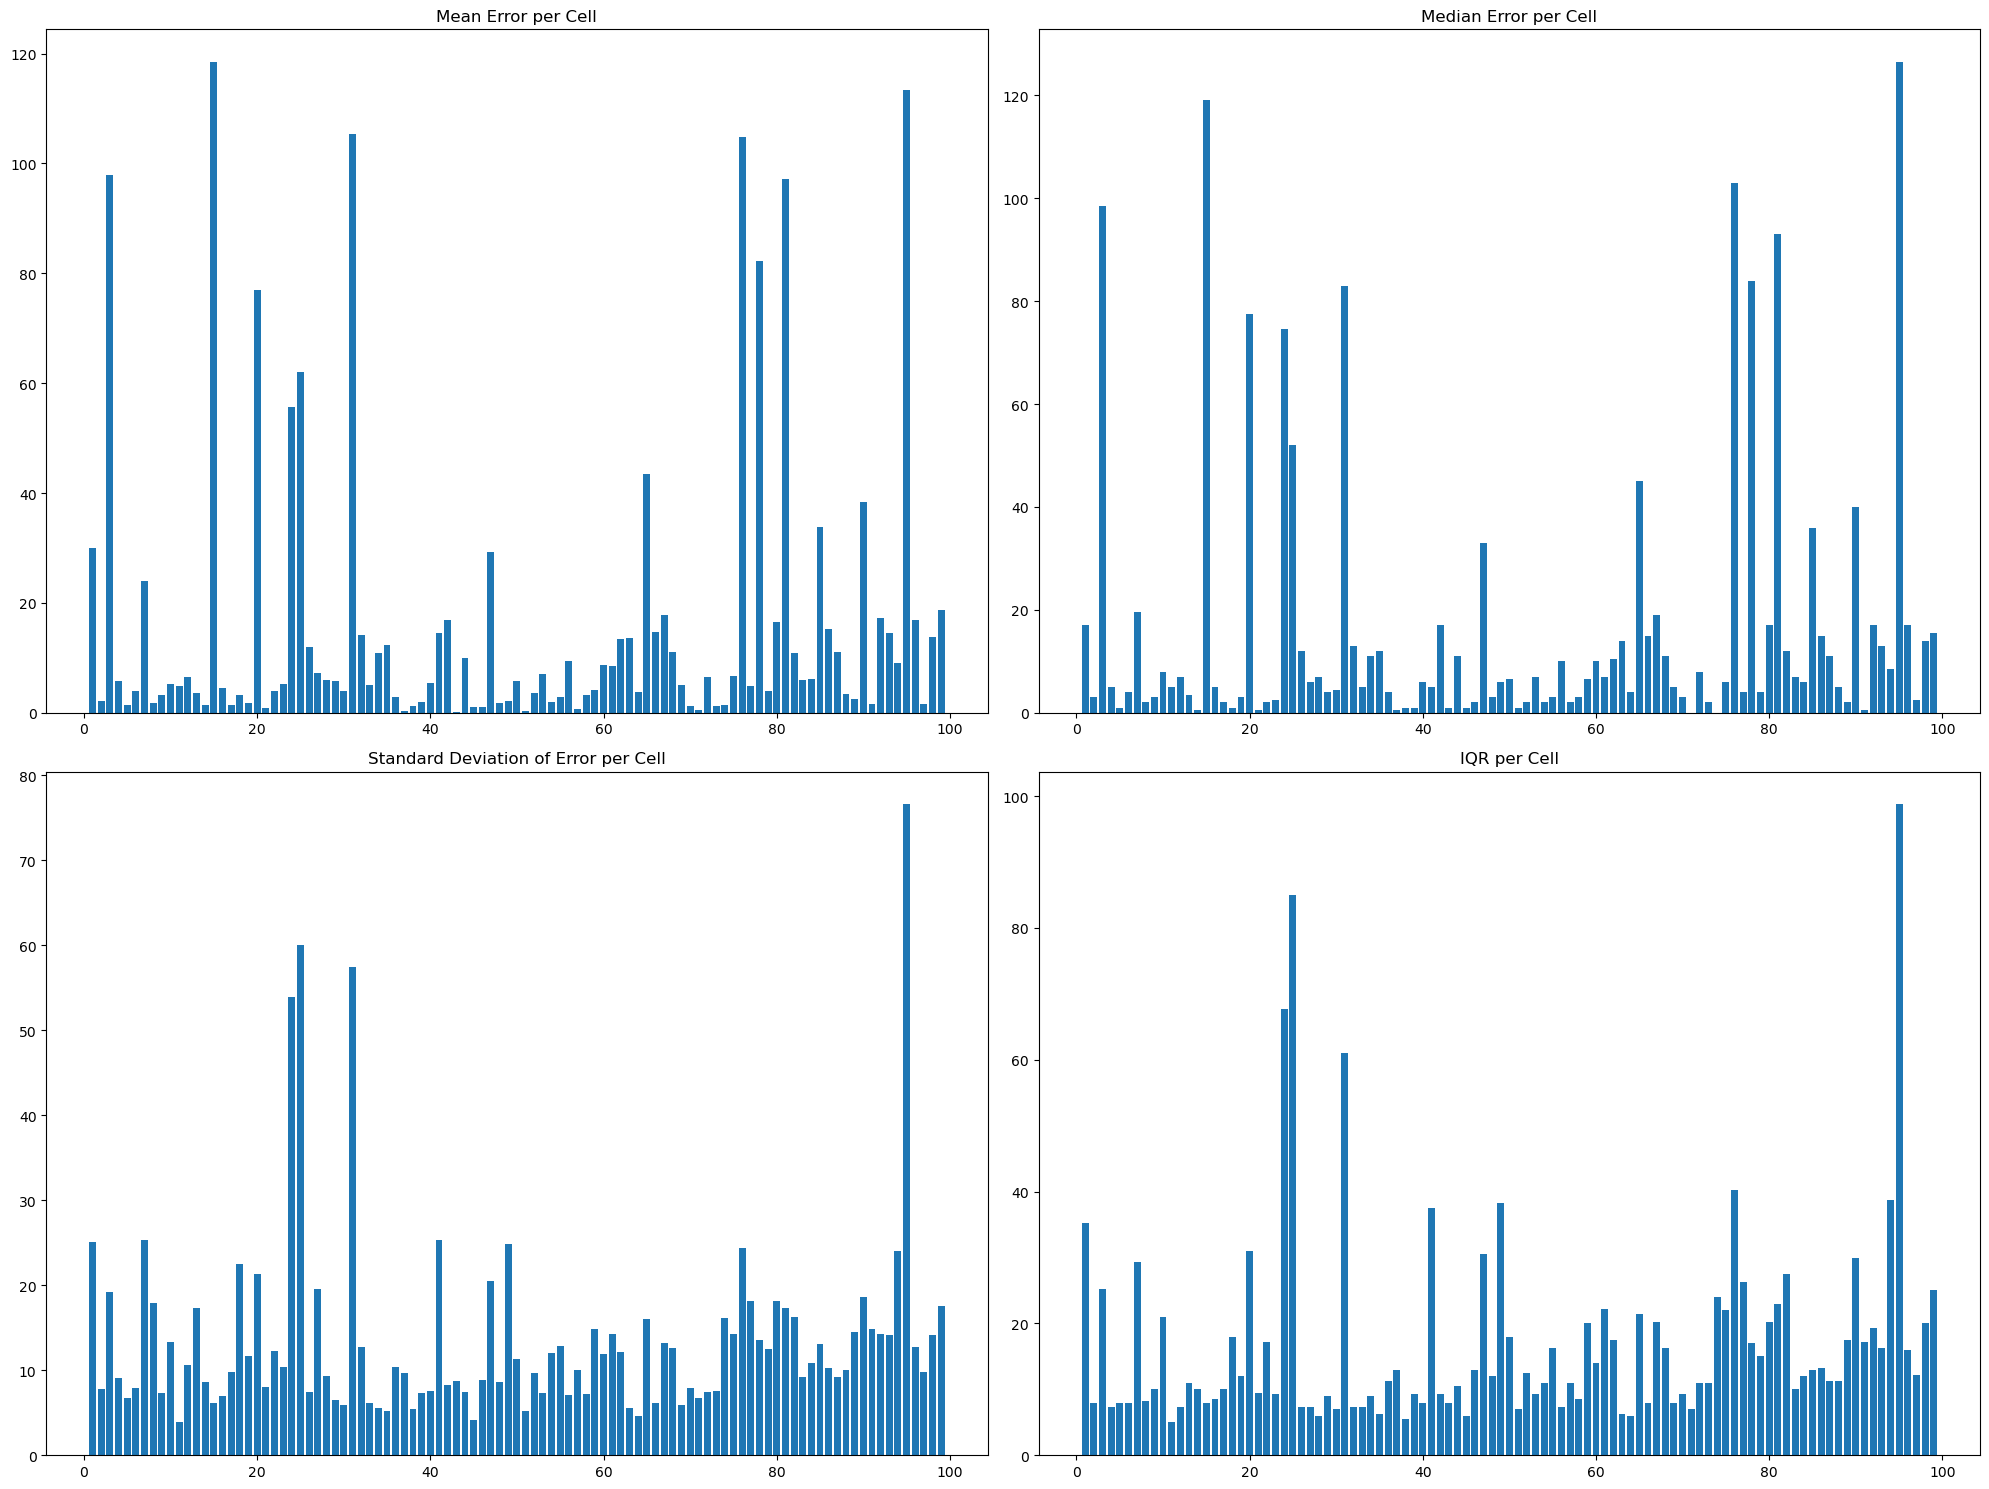

In [28]:
means, medians, std_devs, iqrs = vev.statistic()

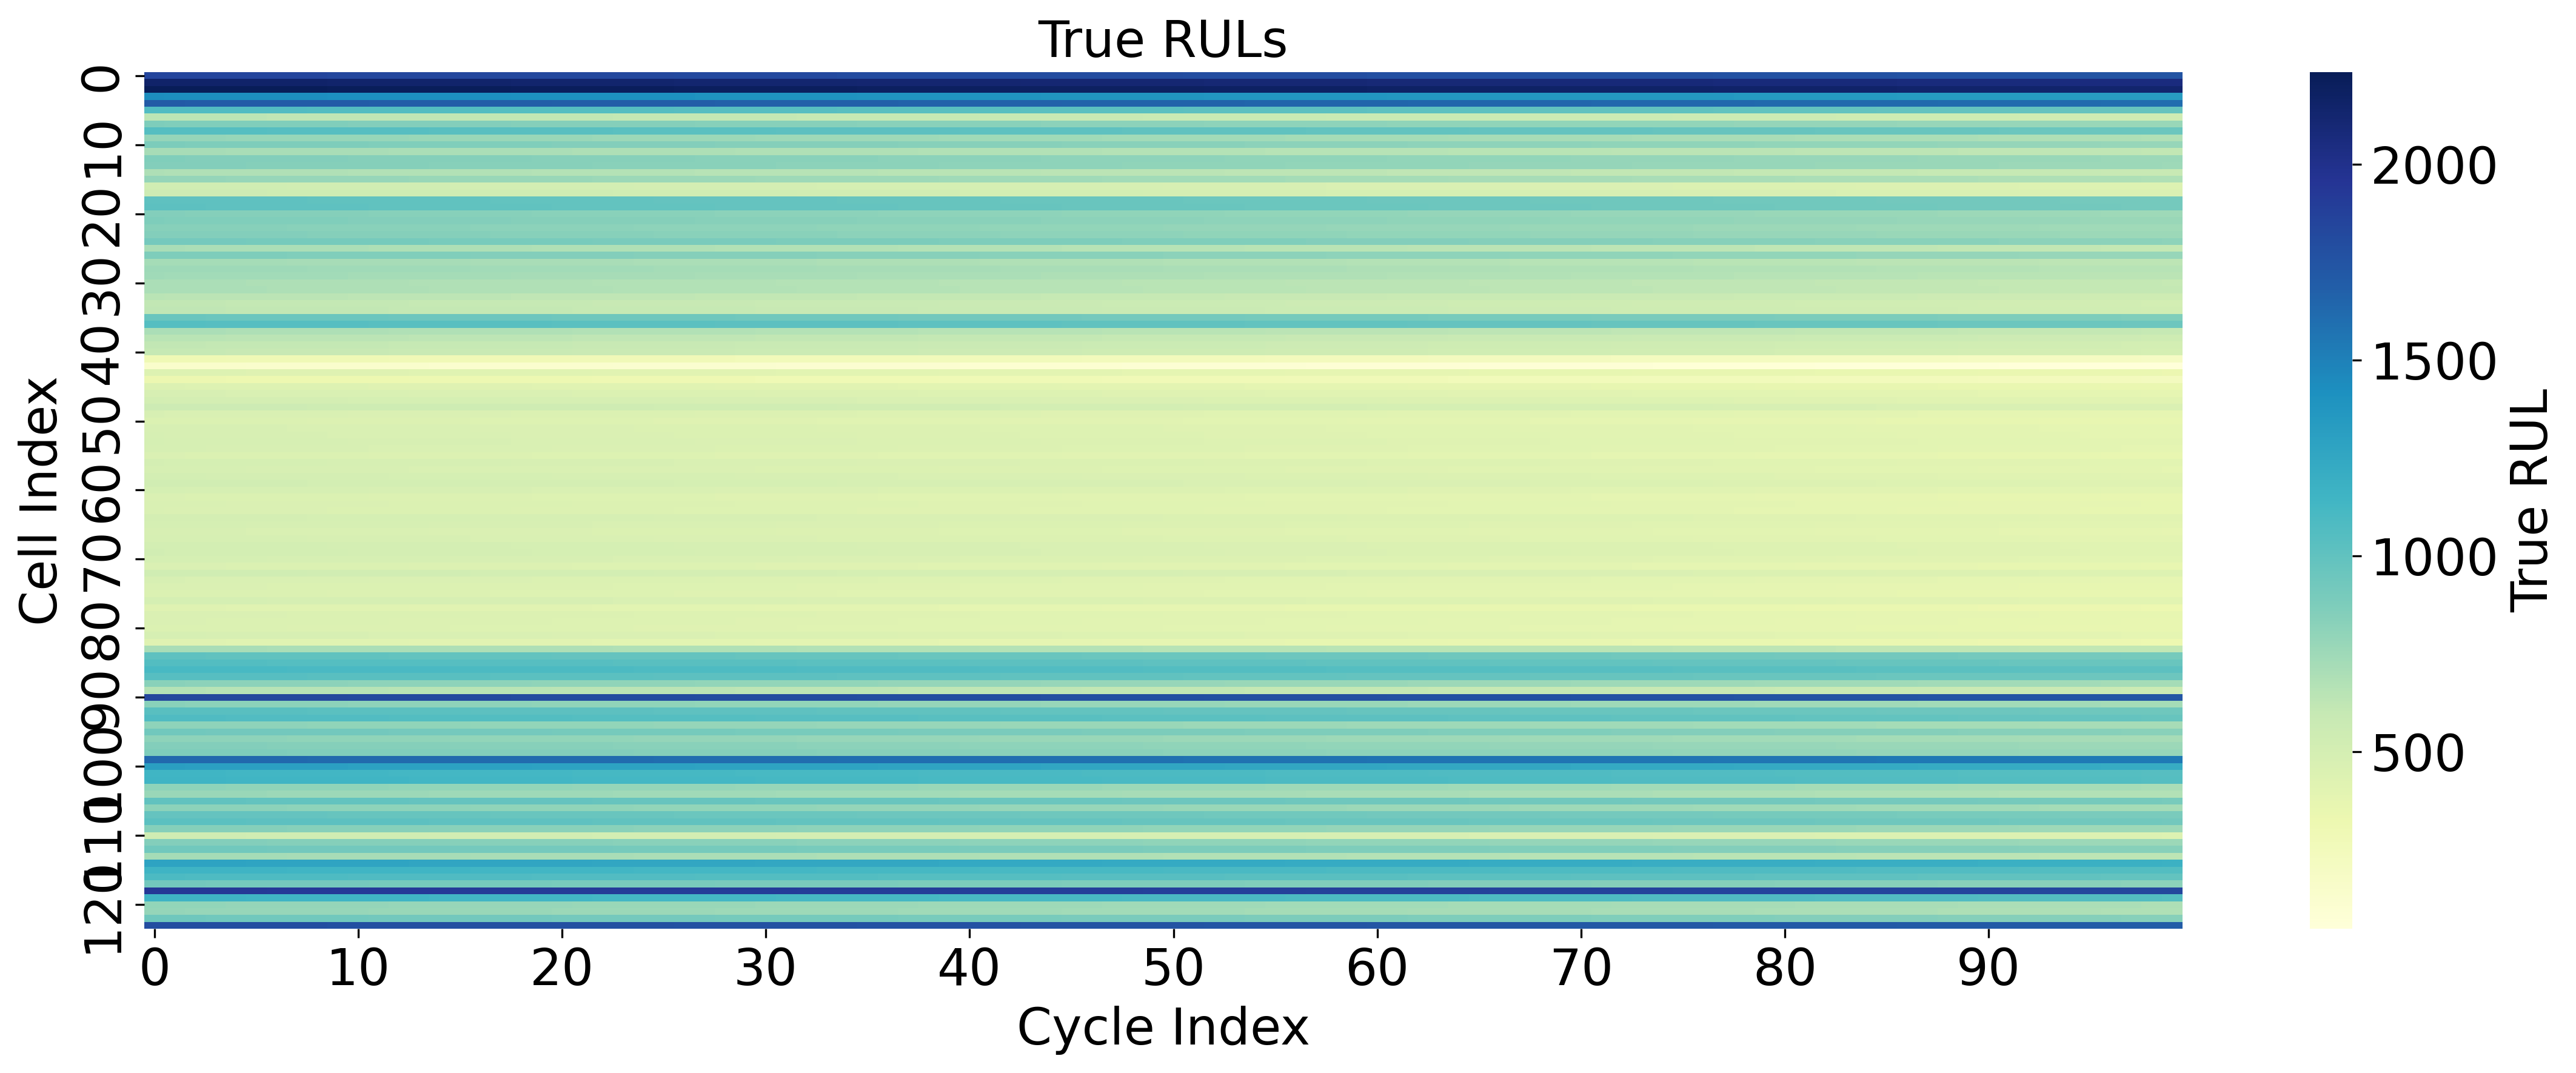

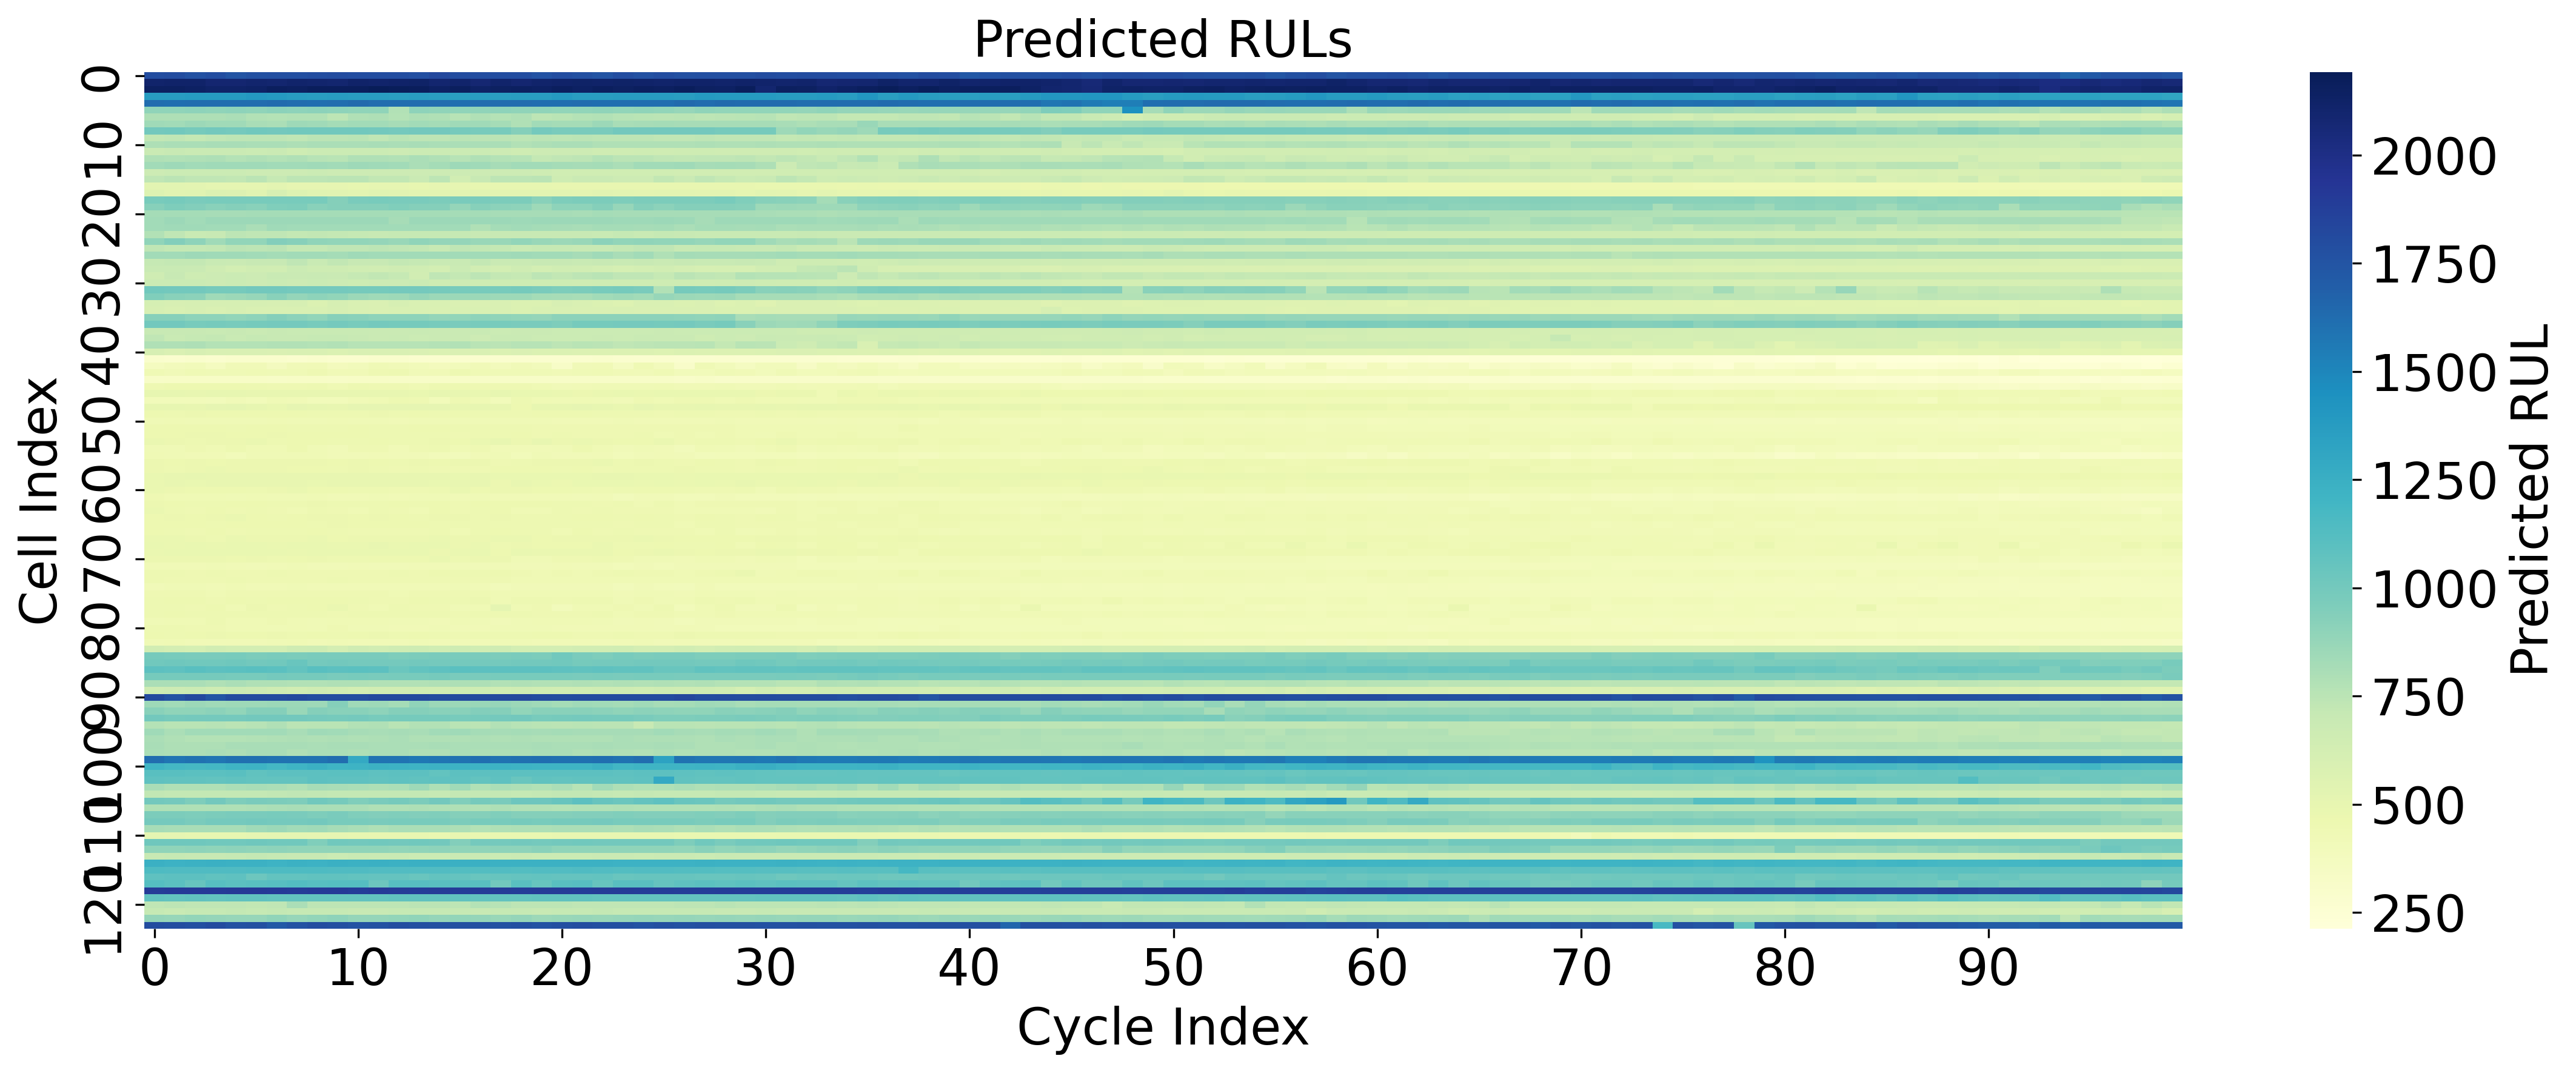

In [35]:
vev.heatmap_separate(title = 'Predicted RULs by ResNet', title_fontsize=20, label_fontsize=20, tick_fontsize=20, 
                 cbar_fontsize=20, dpi=300, max_xticks=10, max_yticks=10)


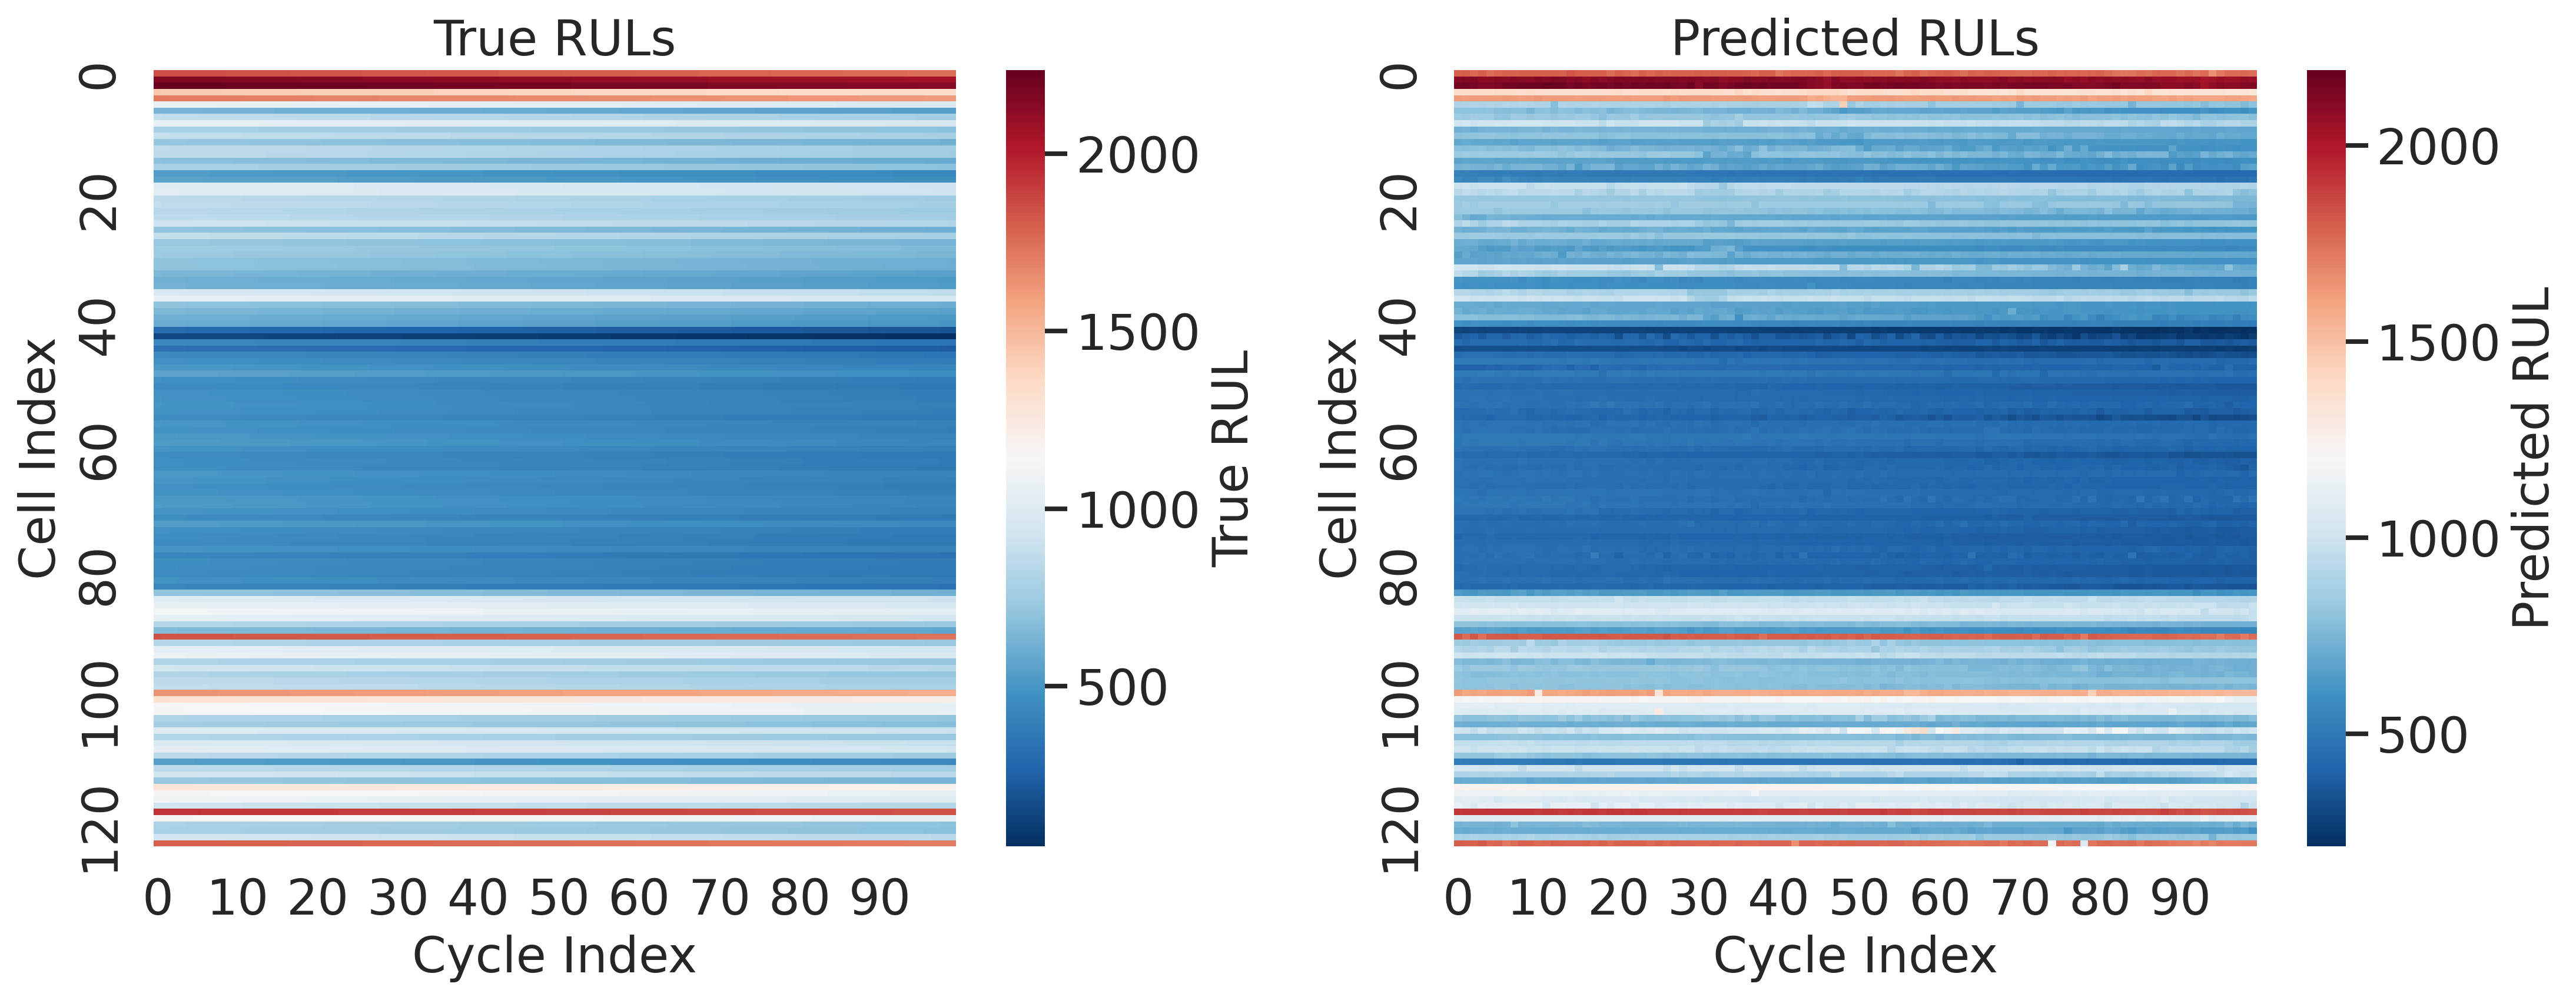

In [52]:
vev.heatmap(title = 'Predicted RULs', cmap_color = 'RdBu_r', title_fontsize=20, label_fontsize=20, tick_fontsize=20, 
                 cbar_fontsize=20, dpi=300, max_xticks=10, max_yticks=20)


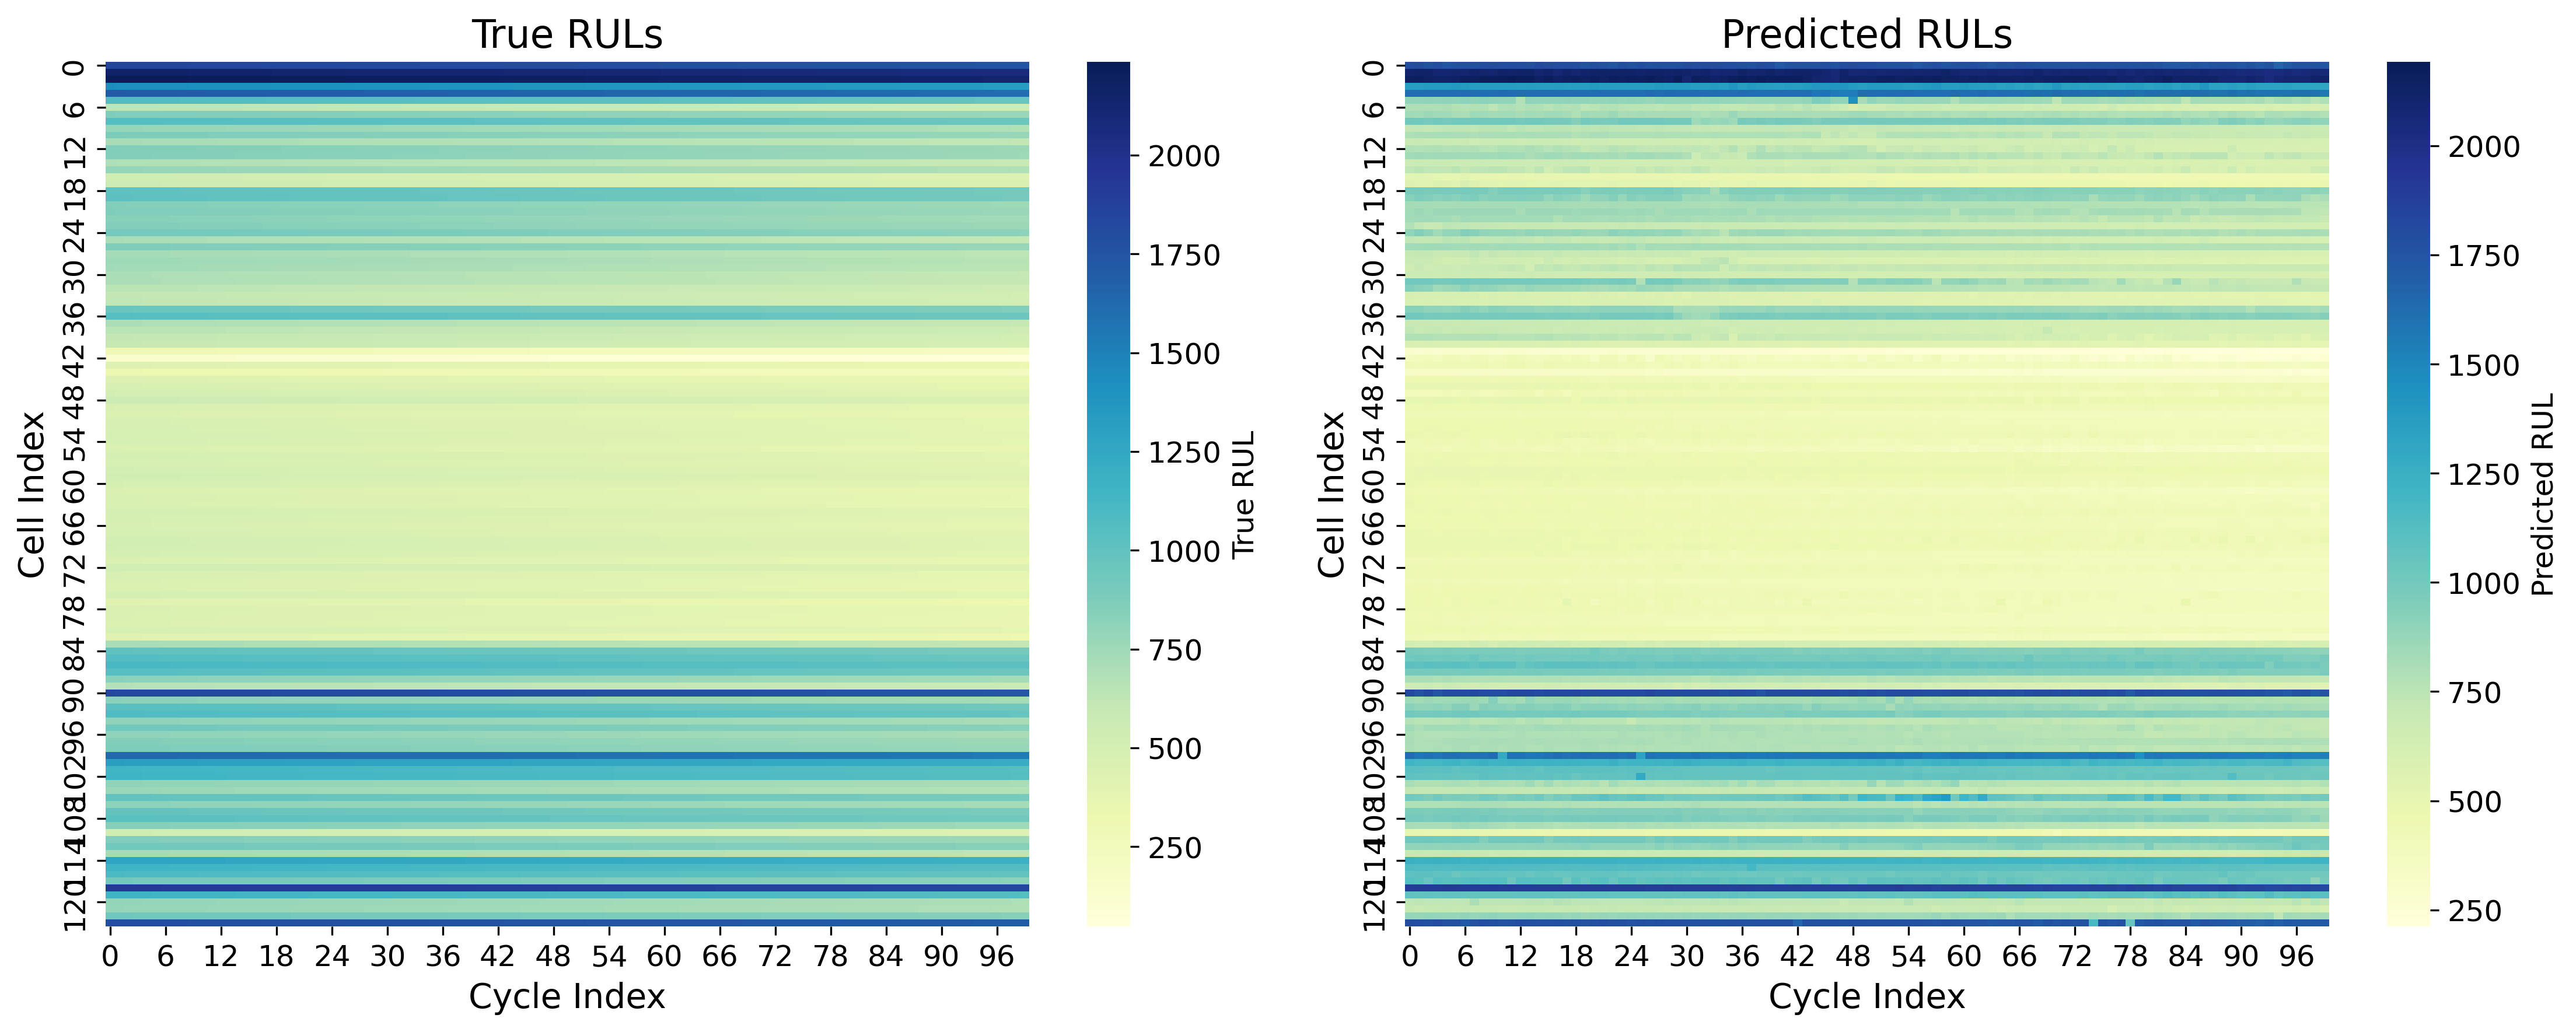

In [29]:
vev.heatmap()

/mnt/d/sandbox/optimal_rul/optimization_v2/ex0/../prediction_evaluation.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt.title(title, fontsize=20)


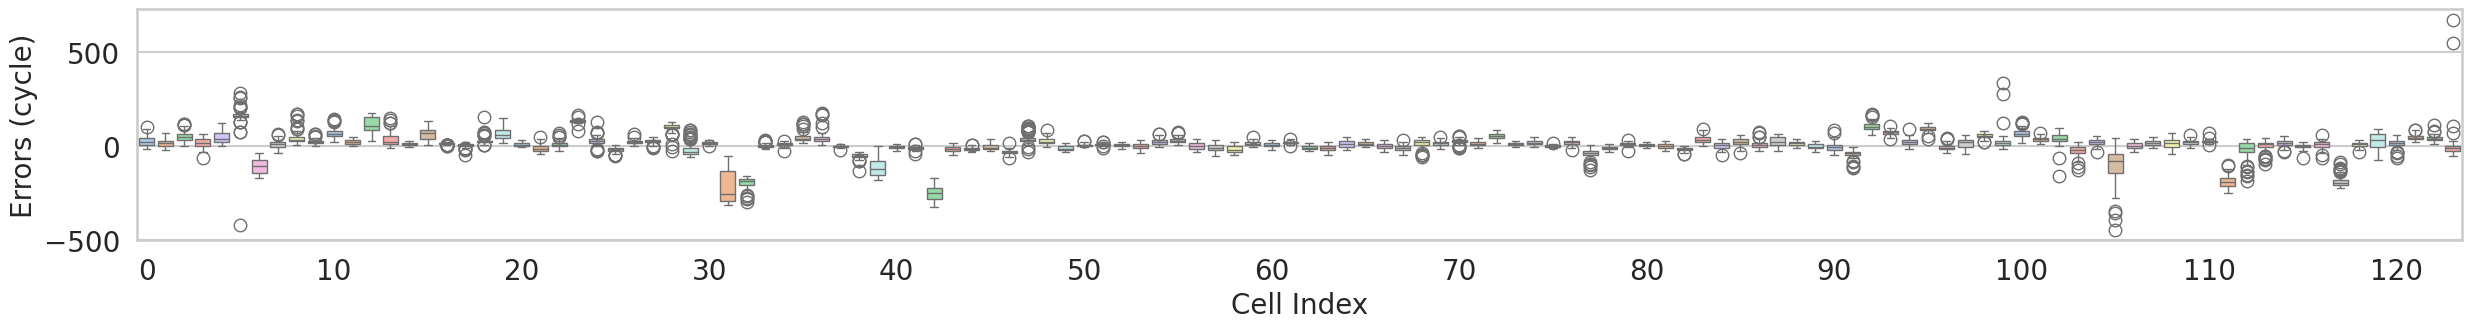

In [55]:
vev.box(None, width = 30, height = 3)

C:\ProgramData\anaconda3\envs\myenv\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\envs\myenv\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\envs\myenv\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\envs\myenv\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\envs\myenv\lib\site-packages\seaborn\

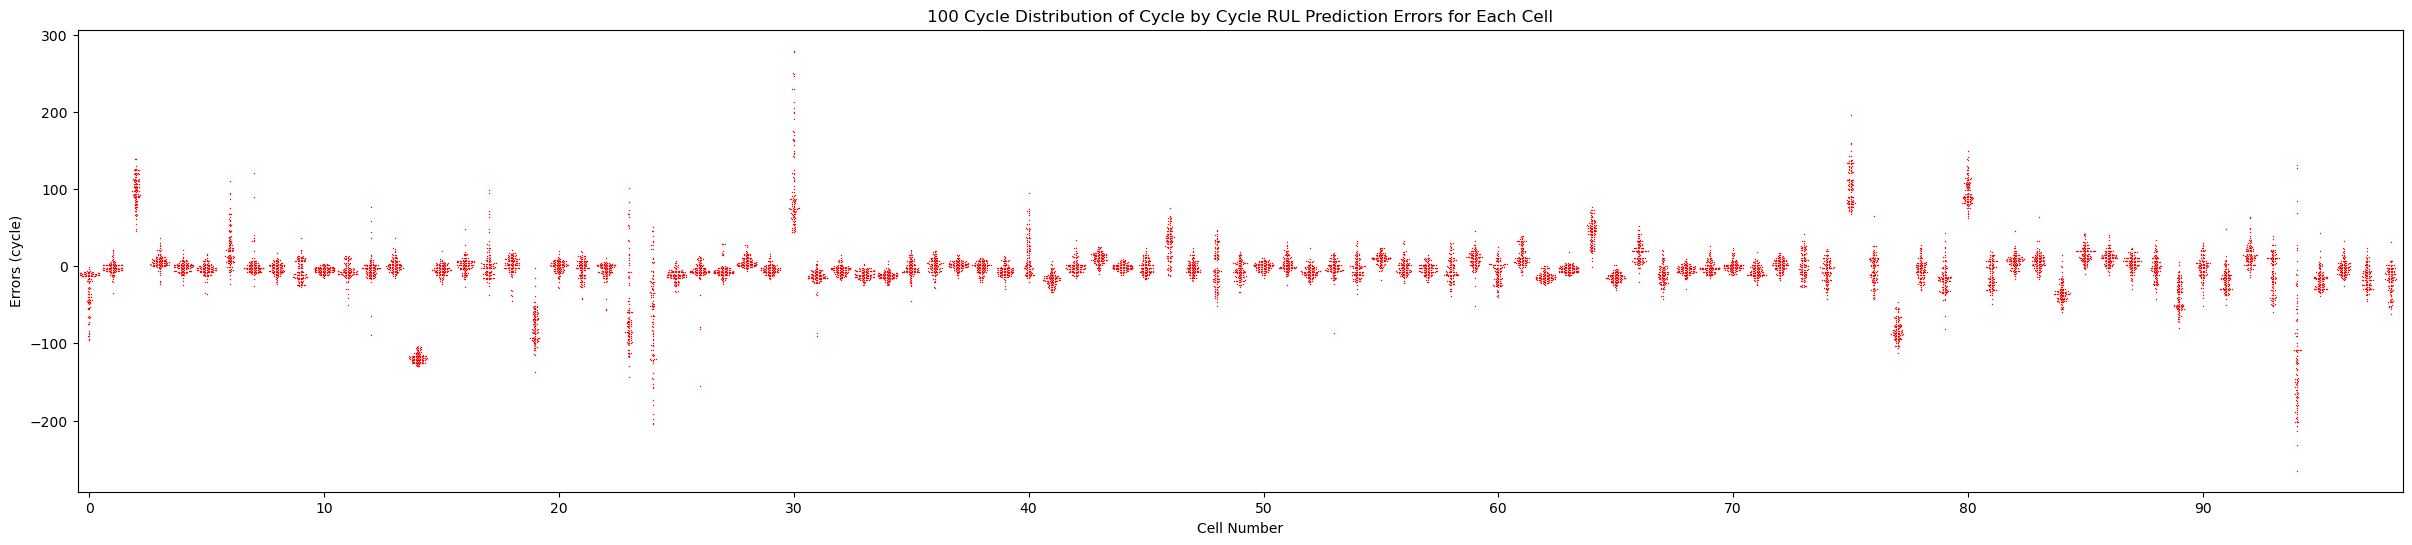

In [31]:
vev.swarm()